<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd

df = pd.read_csv("Restaurant_Reviews.tsv",delimiter = "\t", quoting = 3)
df.head(5)

,Review,Liked
0,Wow... Loved this place.,1
1,Eww,0
2,Crust is not good.,0
3,Not tasty and the texture was just nasty.,0
4,Stopped by during the late May bank holiday of...,1


In [23]:
df.groupby('Liked').describe()

Review                                      
       count unique                       top freq
Liked                                             
0        257    256        Not recommended.      2
1        298    298  Wow... Loved this place.    1

In [24]:
df['Liked'].value_counts()

1    298
0    257
Name: Liked, dtype: int64

In [25]:
def determine_happiness(value):
    return 'happy' if value == 1 else 'not happy'

# Add a new column 'happiness'
df['happiness'] = df['Liked'].apply(determine_happiness)
df.head()

,Review,Liked,happiness
0,Wow... Loved this place.,1,happy
1,Eww,0,not happy
2,Crust is not good.,0,not happy
3,Not tasty and the texture was just nasty.,0,not happy
4,Stopped by during the late May bank holiday of...,1,happy


<h4>Split it into training and test data set</h4>

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Review'],df['Liked'], random_state=10)

In [27]:
X_train.head(4)

188    This movie is so mind-bendingly awful, it coul...
351    When a song could explain the emotions of the ...
139    The characters were all funny and had the pecu...
119    Lewis Black's considerable talent is wasted he...
Name: Review, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

<h4>Build Model</h4>

In [28]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout

# Load pre-trained BERT model from TensorFlow Hub
bert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")

# Define a custom Keras layer for BERT preprocessing
class BERTPreprocessLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_preprocess(inputs)

# Define a custom Keras layer for BERT encoding
class BERTEncoderLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_encoder(inputs)

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = BERTPreprocessLayer()(text_input)
encoded_text = BERTEncoderLayer()(preprocessed_text)

# Extract BERT outputs
sequence_output = encoded_text['sequence_output']  # Get BERT's sequence output

# Define an RNN layer

lstm_layer = LSTM(128, return_sequences=False)

# Bidirectional wrapper for LSTM layer
bidirectional_lstm = Bidirectional(lstm_layer)(sequence_output)

# Dropout layer for regularization
dropout = Dropout(0.1)(bidirectional_lstm)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

# Construct final model
model = tf.keras.Model(inputs=text_input, outputs=output)


In [29]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 bert_preprocess_layer_4 (BERTP  {'input_word_ids':   0          ['text[0][0]']                   
 reprocessLayer)                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [30]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [31]:
model.fit(X_train, y_train, epochs=6, validation_split=0.2)


Epoch 1/6
11/11 [==============================] - 157s 13s/step - loss: 0.4872 - accuracy: 0.7741 - precision: 0.7978 - recall: 0.7845 - val_loss: 0.2363 - val_accuracy: 0.9048 - val_precision: 0.8654 - val_recall: 0.9783
Epoch 2/6
11/11 [==============================] - 150s 14s/step - loss: 0.2123 - accuracy: 0.9157 - precision: 0.9227 - recall: 0.9227 - val_loss: 0.1455 - val_accuracy: 0.9524 - val_precision: 0.9565 - val_recall: 0.9565
Epoch 3/6
11/11 [==============================] - 162s 15s/step - loss: 0.1368 - accuracy: 0.9337 - precision: 0.9492 - recall: 0.9282 - val_loss: 0.1252 - val_accuracy: 0.9524 - val_precision: 0.9565 - val_recall: 0.9565
Epoch 4/6
11/11 [==============================] - 180s 17s/step - loss: 0.0524 - accuracy: 0.9880 - precision: 1.0000 - recall: 0.9779 - val_loss: 0.1495 - val_accuracy: 0.9405 - val_precision: 0.9362 - val_recall: 0.9565
Epoch 5/6
11/11 [==============================] - 179s 17s/step - loss: 0.0226 - accuracy: 0.9970 - precisi

In [32]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 52s 10s/step - loss: 0.4458 - accuracy: 0.8705 - precision: 0.8630 - recall: 0.8873


[0.44581547379493713,
 0.8705036044120789,
 0.8630136847496033,
 0.8873239159584045]

In [33]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

5/5 [==============================] - 53s 10s/step


In [34]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1])

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[58, 10],
       [ 8, 63]], dtype=int64)

Text(33.0, 0.5, 'Truth')

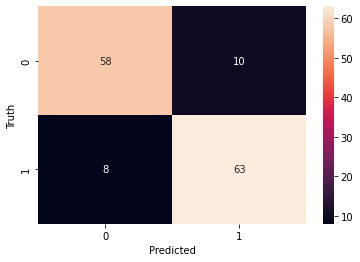

In [36]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        68
           1       0.86      0.89      0.88        71

    accuracy                           0.87       139
   macro avg       0.87      0.87      0.87       139
weighted avg       0.87      0.87      0.87       139



In [39]:
model.save("hate_speech_classification_model_09_30.h5")